# Set transpiler optimization level

Decomposing quantum circuits into the basis gate set of the target device and the addition of SWAP gates needed to match hardware topology causes an increase in the depth and gate count of quantum circuits. To mitigate this increased complexity, you can set the `optimization_level`.  Setting this value calls an optimization routine that optimizes the transpilation process by combining or eliminating gates and by optionally using algorithms to find an optimal layout (depending on the level chosen). 

In some cases these methods are so effective the output circuits have lower depth than the inputs. In other cases, not much can be done, and the computation may be difficult to perform on noisy devices. Choosing the best optimization level might take trial and error, as it depends heavily on the circuit being transpiled and the system being targeted.

Higher optimization levels generate more optimized circuits at the expense of longer compile times.  By default, `optimization_level=1` is used. 

- `optimization_level=0`: Trivial optimization, which maps the circuit to the system with no explicit optimization.
- `optimization_level=1-3`: Increasingly complex optimization, with heuristic algorithms that are used to find a layout and insert SWAP gates, with the goal of improving the overall performance of the circuit.  The number of iterations that these algorithms run increases with higher optimization levels. 

Because finding the best layout is an NP-hard problem, it is the most time-consuming part of the transpilation process.  However, Qiskit SDK uses stochastic algorithms that have been refactored into Rust, resulting in significant speedup.  Therefore, optimization levels 1-3 all use the same layout algorithms.  There are some slight differences in how the circuits are translated into basis gates, as described in the following table:


<Table>
  <thead>
    <Tr>
      <Th>Optimization Level</Th>
      <Th>Description</Th>
    </Tr>
  </thead>
  <tbody>
    <Tr>
      <Td>0</Td>
      <Td>
        No optimization: typically used for hardware characterization
        - Basic translation
        - Layout/Routing: `TrivialLayout`, where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using `StochasticSwap`)
      </Td>
    </Tr>
    <Tr>
      <Td>1</Td>
      <Td>
        Light optimization (default):
        -   Layout/Routing: Layout is first attempted with `TrivialLayout`. If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using `SabreSWAP`, then it uses `VF2LayoutPostLayout` to try to select the best qubits in the graph.
        -   `InverseCancellation`
        -   1Q gate optimization
      </Td>
    </Tr>
    <Tr>
      <Td>2</Td>
      <Td>
        Medium optimization:
          - Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater
        search depth and trials of optimization function.  Because `TrivialLayout` is not used, there is no attempt to use the same physical and virtual qubit numbers. 
        -   `CommutativeCancellation`
      </Td>
    </Tr>
    <Tr>
      <Td>3</Td>
      <Td>
        High Optimization:
        - Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
        - Resynthesis of two-qubit blocks using [Cartan's KAK Decomposition](https://arxiv.org/abs/quant-ph/0507171). 
        - Unitarity-breaking passes: 
          * `OptimizeSwapBeforeMeasure`: Moves the measurements around to avoid SWAPs
          * `RemoveDiagonalGatesBeforeMeasure`: Removes gates before measurements that would not effect the measurements
      </Td>
    </Tr>
  </tbody>
</Table>

## Optimization level in action

Since CX is the noisiest gate, we can quantify the transpilation's "hardware efficiency" by counting the CX gates in the resulting circuit. We will compare the default transpilation levels given the same circuit. 

Next we build a quantum circuit consisting of a random unitary followed by a SWAP gate. The `random_unitary` method is seeded to ensure reproducible results.

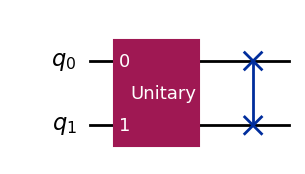

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator, random_unitary

UU = random_unitary(4, seed=12345)
rand_U = UnitaryGate(UU)

qc = QuantumCircuit(2)
qc.append(rand_U, range(2))
qc.swap(0, 1)
qc.draw('mpl', style="iqp")

We use `FakeTokyo` as the system and transpile using `optimization_level=1` (the default). To avoid considering the effect of idle qubits, We override the system's coupling map so that the transpiled circuit returns to a two-qubit circuit.

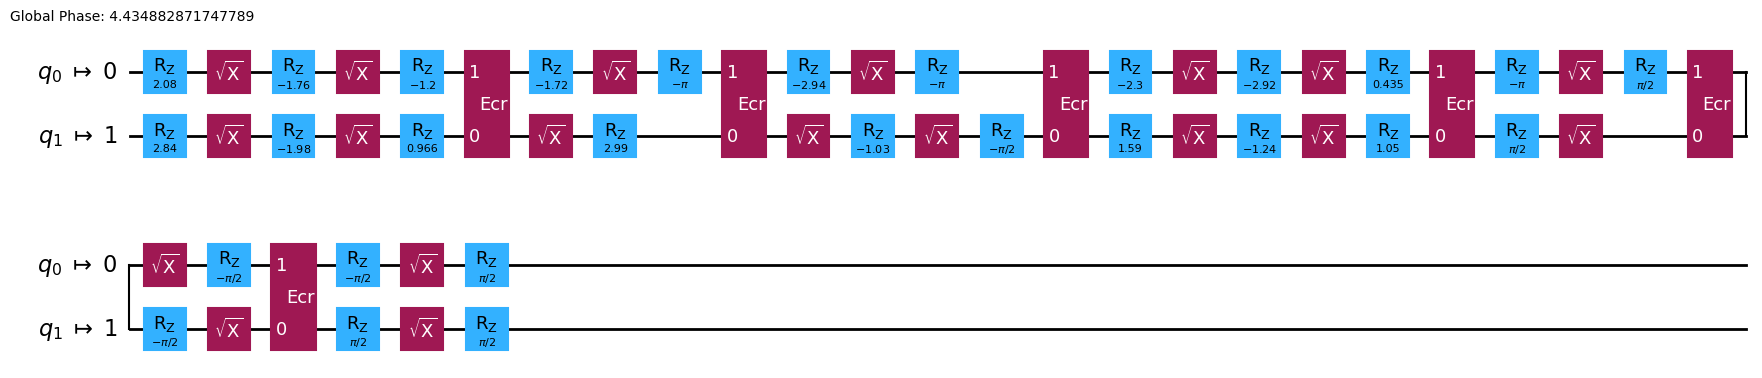

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=12345)
qc_t1_exact = pass_manager.run(qc)
qc_t1_exact.draw('mpl', idle_wires=False)

The transpiled circuit has six CX gates and several `U3` gates, which have much lower error than CX's, so we don't need to count them. 

Repeat for optimization level 2: 

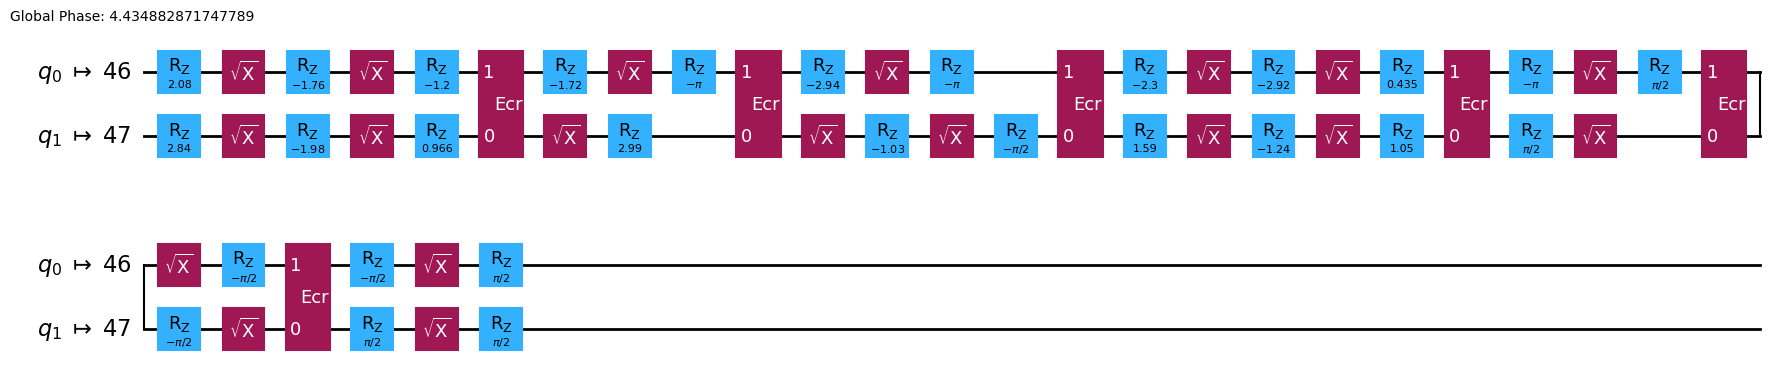

In [3]:
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend, seed_transpiler=12345)
qc_t2_exact = pass_manager.run(qc)
qc_t2_exact.draw('mpl', idle_wires=False)

This yields the same results as optimization level 1. Note that increasing the level of optimization does not always make a difference. 

Repeat again, with optimization level 3:

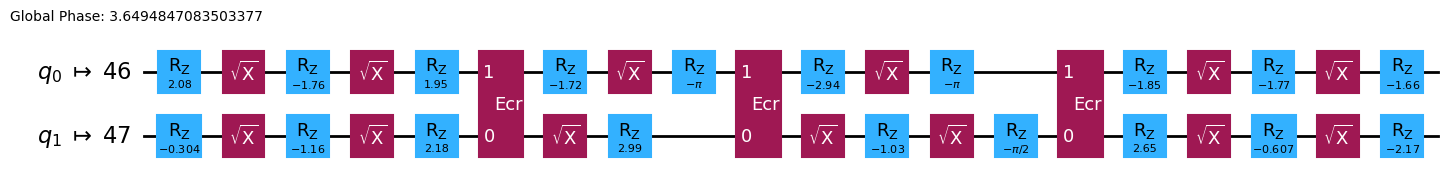

In [4]:
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=12345)
qc_t3_exact = pass_manager.run(qc)
qc_t3_exact.draw('mpl', idle_wires=False)

Now there are only three CX gates. This is because with optimization level 3, Qiskit tries to re-synthesize two-qubit blocks of gates. Since any two-qubit gate requires at most three CX gates, we get the above result. We can get even fewer CX gates if we sacrifice the fidelity of this synthese by setting `approximation_degree` to a value less than 1:

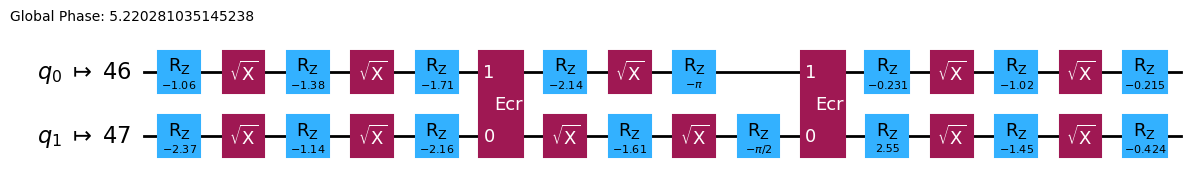

In [5]:
pass_manager = generate_preset_pass_manager(optimization_level=3, approximation_degree=0.99, backend=backend, seed_transpiler=12345)
qc_t3_approx = pass_manager.run(qc)
qc_t3_approx.draw('mpl', idle_wires=False)

This circuit has only two CX gates, but it's an approximate circuit. To understand how its effect differs from the exact circuit, we can calculate its fidelity, as in the cell below. Before performing the computation, we first reduce the transpiled circuit, which contains 127 qubits, down to a circuit that only contains the active qubits, of which there are two.

In [8]:
import numpy as np
from qiskit.synthesis.two_qubit.two_qubit_decompose import trace_to_fid

# Reduce circuits down to 2 qubits so they are easy to simulate
qc_t3_exact_small = QuantumCircuit.from_instructions(qc_t3_exact)
qc_t3_approx_small = QuantumCircuit.from_instructions(qc_t3_approx)

# Compute the fidelity
exact_fid = trace_to_fid(np.trace(np.dot(Operator(qc_t3_exact_small).adjoint().data, UU)))
approx_fid = trace_to_fid(np.trace(np.dot(Operator(qc_t3_approx_small).adjoint().data, UU)))
print(f'Synthesis fidelity\nExact: {exact_fid:.3f}\nApproximate: {approx_fid:.3f}')

Synthesis fidelity
Exact: 1.000
Approximate: 0.992


Adjusting the optimization level can change other aspects of the circuit too, not just the number of CX gates. For examples of how setting optimization level changes the layout, see [Representing quantum computers](representing_quantum_computers).

## Next steps

<Admonition type="tip" title="Recommendations">
    - To learn how to use the `transpile` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Continue learning about transpilation with the [Transpiler stages](transpiler-stages) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Try the [Build repetition codes](https://learning.quantum.ibm.com/tutorial/build-repetition-codes) tutorial.
    - See the [Transpile API documentation.](/api/qiskit/transpiler)
</Admonition>